# Spin-Flip Simulation

In this guide, you will learn how to load the Hamiltonian of a spin system,
compute the energy levels of the Hamiltonian, and simulate the evolution
of the corresponding system in time.
We will use the Hamiltonian describing Acrylonitride
($\mathrm{C}_2 \mathrm{H}_3 \mathrm{CN}$) in a magnetic field, as you
would encounter, e.g., in an NMR spectrometer.

First, we need to import the functions, classes and modules that are required
for the script. Therefore, we create a Python script and add the following
imports to our file, which we will explain, as we go along.

In [1]:
# Title    : HQS Quantum Solver Spin Flip Simulation
# Filename : spin_flip.py
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh

from struqture_py.spins import PauliHamiltonian

from hqs_quantum_solver.spins import (
    VectorSpace, Operator, lowering, struqture_term, spin_z, raising
)
from hqs_quantum_solver.evolution import evolve_krylov, observers

# License check turned off for lattice_functions.
# License check turned off for lattice_solver.


Next, we load the Hamiltonian description from a file in
Struqture format.
[Struqture](https://github.com/HQSquantumsimulations/struqture) is
a library providing an exchage format for quantum operators.
(See the "[Struqture](struqture.md)" section for more information about
using Struqture with Quantum Solver.)
We have to store the file [acrylonitride.json](spin-flip/acrylonitride.json)
(right click, "Save As..."), which contains the description of the
Hamiltonian, in the same directory as the Python script.
Afterwards, we can load it as follows.

In [2]:
filepath = Path("acrylonitride.json")
hamiltonian_info = PauliHamiltonian().from_json(filepath.read_text())

So far, we have only loaded a description of a Hamiltonian. To use it,
we need to turn it into an actual Operator that, e.g., can be applied
to a state vector. In addition to the definition of the operator,
Quantum Solver needs the vector space that the operator is defined on.
Since we are dealing with a spin system, we create a
[VectorSpace](https://docs.cloud.quantumsimulations.de/hqs-quantum-solvers/reference/generated/hqs_quantum_solver.spins.html#hqs_quantum_solver.spins.VectorSpace) object from the
[spins](https://docs.cloud.quantumsimulations.de/hqs-quantum-solvers/reference/generated/hqs_quantum_solver.spins.html) module.
Vector spaces, as used in quantum mechanics, are defined by the states
they represent. The states of the system are defined by the
`sites` and the `total_spin_z` arguments. The former sets the number of
spins in the system, and the latter can be used to only include states
with a given total spin polarization. Since we want to include all
states, we set `total_spin_z` to `"all"`.

In [3]:
v = VectorSpace(sites=hamiltonian_info.current_number_spins(), total_spin_z="all")

Having constructed the vector space, we can now create the Hamiltonian
as an instance of type
[Operator](https://docs.cloud.quantumsimulations.de/hqs-quantum-solvers/reference/generated/hqs_quantum_solver.spins.html#hqs_quantum_solver.spins.Operator).

In [4]:
hamiltonian = Operator(struqture_term(hamiltonian_info), domain=v, dtype=complex)

Herein, we used the [struqture_term](https://docs.cloud.quantumsimulations.de/hqs-quantum-solvers/reference/generated/hqs_quantum_solver.spins.html#hqs_quantum_solver.spins.struqture_term)
function to tell Quantum Solver that the input is in Struqture format.
Furthermore, we enforced the construction of a complex-valued operator
by setting `dtype` to `complex`. (Setting `dtype` is optional,
but since we want to compute a time evolution of the system, which requires
complex state vectors, having a complex operator yields better performance.)

We can now obtain the energy levels of the system by computing the
eigenvalues of the operator. The
[Operator](https://docs.cloud.quantumsimulations.de/hqs-quantum-solvers/reference/generated/hqs_quantum_solver.spins.html#hqs_quantum_solver.spins.Operator) class is compatible to
SciPy, such that we can directly call the
[eigsh](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigsh.html#scipy.sparse.linalg.eigsh) on the operator, and then use
[Matplotlib](https://matplotlib.org/) to plot the result.
(Note that the [eigsh](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigsh.html#scipy.sparse.linalg.eigsh) function does not
return the eigenvalues in a sorted order when the operator is complex.)

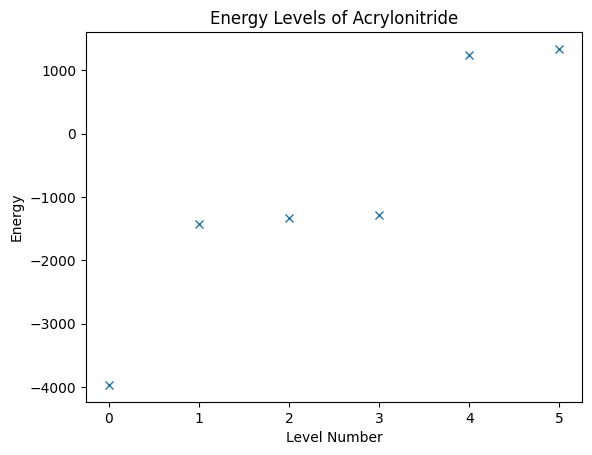

In [5]:
eigvals, eigvecs = eigsh(hamiltonian, k=6, which="SA")
sorted_indices = np.argsort(eigvals)

plt.figure("energy-levels")
plt.title("Energy Levels of Acrylonitride")
plt.xlabel("Level Number")
plt.ylabel("Energy")
plt.plot(eigvals[sorted_indices], "x")

Running the script up to this point should result in an image as shown
below.


We shall now turn to the simulation of the time evolution of the system
described by the Hamiltonian. The first thing that we need is to setup
the initial wave function of the system. For that, we want to take the
groundstate of the system and flip one of the spins.
Flipping the $j$th spin is done by applying the operator
$(\hat{S}_j^+ + \hat{S}_j^-)$, which needs to be built first.

Quantum Solver has a selection of high-level functions that can be used to
describe operators. For our purpose we use the
[raising](https://docs.cloud.quantumsimulations.de/hqs-quantum-solvers/reference/generated/hqs_quantum_solver.spins.html#hqs_quantum_solver.spins.raising) and
[lowering](https://docs.cloud.quantumsimulations.de/hqs-quantum-solvers/reference/generated/hqs_quantum_solver.spins.html#hqs_quantum_solver.spins.lowering) functions, which
describe the $\hat{S}^+$ and $\hat{S}^-$ operator, respectively.
Since Quantum Solver allows for building of arbitrary linear combinations
of those operator descriptions, we can build the desired spin-flip
operator for the site with index 2 as follows.

In [6]:
flip = Operator(raising(site=2) + lowering(site=2), domain=v, dtype=complex)

The spin-flip operator can be applied to a wave function by using the `.dot`
method of the operator.

In [7]:
groundstate = eigvecs[:, sorted_indices[0]]
initial_wavefunction = flip.dot(groundstate)

Since inspecting the wave function directly is usually not very insightful,
we need to perform an additional step, before we run a time simulation.
We want to look at the expectation value of observables,
in this case the spin polarizations $\hat{S}^z_j$
for all sites of the system.
The operator $\hat{S}^z_j$ is described by the
[spin_z](https://docs.cloud.quantumsimulations.de/hqs-quantum-solvers/reference/generated/hqs_quantum_solver.spins.html#hqs_quantum_solver.spins.spin_z) function, and we can create
a list of all desired observables in the following way.

In [8]:
observables = [
    Operator(spin_z(site=j), domain=v, dtype=complex) for j in range(v.sites)
]

With the observables at hand, we can now create an list containing the
time values at which we want to evaluate the wave function,
call the [evolve_krylov](https://docs.cloud.quantumsimulations.de/hqs-quantum-solvers/reference/generated/hqs_quantum_solver.evolution.html#hqs_quantum_solver.evolution.evolve_krylov)
function to perform the simulation, and then stack the list of observations
into a single NumPy array.

In [9]:
ts = np.linspace(0, 1e-1, 100)
result = evolve_krylov(
    hamiltonian, initial_wavefunction, ts,
    observer=observers.expectation(observables)
)
observations = np.stack(result.observations)

The result can then be visualized using the code below.

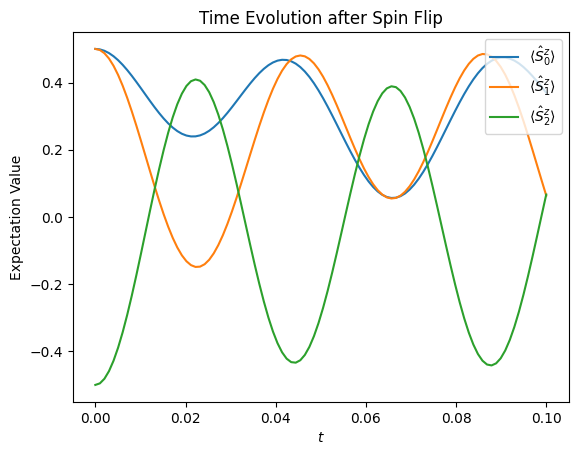

In [10]:
plt.figure("time-evolution")
plt.title("Time Evolution after Spin Flip")
plt.xlabel("$t$")
plt.ylabel("Expectation Value")
for j in range(observations.shape[1]):
    plt.plot(ts, observations[:, j], label=f"$\\langle \\hat{{S}}^z_{j} \\rangle$")
plt.legend(loc="upper right")
plt.show()

## Complete Code

```python
# Title    : HQS Quantum Solver Spin Flip Simulation
# Filename : spin_flip.py
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh

from struqture_py.spins import PauliHamiltonian

from hqs_quantum_solver.spins import (
    VectorSpace, Operator, lowering, struqture_term, spin_z, raising
)
from hqs_quantum_solver.evolution import evolve_krylov, observers

# ===== Loading and Building the Hamiltonian =====

filepath = Path("acrylonitride.json")
hamiltonian_info = PauliHamiltonian().from_json(filepath.read_text())

v = VectorSpace(sites=hamiltonian_info.current_number_spins(), total_spin_z="all")
hamiltonian = Operator(struqture_term(hamiltonian_info), domain=v, dtype=complex)

# ===== Energy Levels =====

eigvals, eigvecs = eigsh(hamiltonian, k=6, which="SA")
sorted_indices = np.argsort(eigvals)

plt.figure("energy-levels")
plt.title("Energy Levels of Acrylonitride")
plt.xlabel("Level Number")
plt.ylabel("Energy")
plt.plot(eigvals[sorted_indices], "x")

# ===== Spin Flip =====

flip = Operator(raising(site=2) + lowering(site=2), domain=v, dtype=complex)

groundstate = eigvecs[:, sorted_indices[0]]
initial_wavefunction = flip.dot(groundstate)

# ===== Time Evolution =====

observables = [
    Operator(spin_z(site=j), domain=v, dtype=complex) for j in range(v.sites)
]

ts = np.linspace(0, 1e-1, 100)
result = evolve_krylov(
    hamiltonian, initial_wavefunction, ts,
    observer=observers.expectation(observables)
)
observations = np.stack(result.observations)

plt.figure("time-evolution")
plt.title("Time Evolution after Spin Flip")
plt.xlabel("$t$")
plt.ylabel("Expectation Value")
for j in range(observations.shape[1]):
    plt.plot(ts, observations[:, j], label=f"$\\langle \\hat{{S}}^z_{j} \\rangle$")
plt.legend(loc="upper right")
plt.show()
```